In [1]:
import numpy as np
import pandas as pd 
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, learning_curve
from sklearn.model_selection import learning_curve
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import optuna
import torch.nn.functional as F
import os
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
%matplotlib inline
import random
import sys

!python -m spacy download el_core_news_sm
import spacy

!pip install greek-stemmer-pos
from greek_stemmer import stemmer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 63.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 9.3 MB/s eta 0:00:00
/kaggle/input/ys19-2023-assignment-3/sample_submission.csv
/kaggle/input/ys19-2023-assignment-3/test_set.csv
/kaggle/input/ys19-2023-assignment-3/valid_set.csv
/kaggle/input/ys19-2023-assignment-3/train_set.csv


In [2]:
df = pd.read_csv("../input/ys19-2023-assignment-3/train_set.csv")
df_valid_csv = pd.read_csv("../input/ys19-2023-assignment-3/valid_set.csv")
df_test_csv = pd.read_csv("../input/ys19-2023-assignment-3/test_set.csv")

nlp = spacy.load("el_core_news_sm")
line_vectors = []
special_characters = "!@#$%^&*()-_+[]{}|;:'\"<>,.?/~`«»"
extra_stopwords = ['ότι', 'για', 'θα', 'την', 'του', 'να', 'στο', 'στου', 'στον', 'στην', 'στη', 'στα', 'και', 'οτι', 'ένα', 'ενα', 'δύο', 'δυο', 'ε', 'σε', 
                   'σου', 'πιο', 'όπως', 'οπως', 'άλλος', 'ως', 'ας', 'έτσι', 'αυτός', 'ένας', 'γιατί', 'γιατι', 'μου', 'κλπ', 'επί', 'όταν', 'είμαι', 
                   'ειμαι', 'είναι', ' ', '  ', '   ', '    ', 'έχω', 'εχω', 'ενώ', 'εγώ', 'τώρα', 'εγω', 'ή', 'σαν', 'σε ο', 'από', 'όπως', 'από', 'απο',
                   'όλοι', 'ολοι', 'όλα', 'ολα']

# Remove URLs, mentions, special characters and lowercasing
def clean_tweet(line):
    line = re.sub(r'http\S+', '', line)
    line = re.sub(r'@[A-Za-z0-9]+', '', line) 
    line = line.lower()
    for char in special_characters:
        line = line.replace(char, ' ')
    return line

# Tokenization and stemming
def clean_word_vector(line):
    filtered_vector = []
    text = nlp(line)
    for token in text:
        token = token.lemma_
        if ' ' not in token and token not in stopwords.words('greek') and token not in extra_stopwords:
            token = stemmer.stem_word(token, 'VBG')
            filtered_vector.append(token)
    return filtered_vector


# Preprocess every line and generate word vector
for index, row in df.iterrows():  #for each line
    line = clean_tweet(row["Text"])
    line_vectors.append(clean_word_vector(line))
    
line_vectors_valid = []
for index, row in df_valid_csv.iterrows():  #for each line
    line_valid = clean_tweet(row["Text"])
    line_vectors_valid.append(clean_word_vector(line_valid))
    
line_vectors_test_csv = []
for index, row in df_test_csv.iterrows():  #for each line
    line_valid = clean_tweet(row["Text"])
    line_vectors_test_csv.append(clean_word_vector(line_valid))

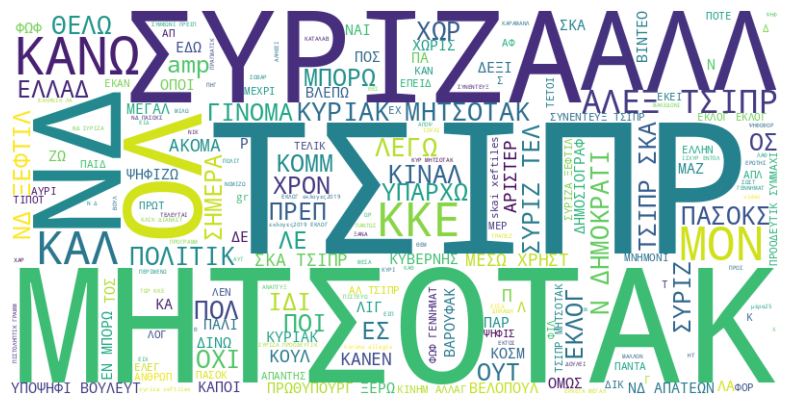

In [3]:
# Create a WordCloud 
text_for_wordcloud = ' '.join([' '.join(line) for line in line_vectors])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [4]:
# Count the frequency of each token
flat_word_vectors = [token for line in line_vectors for token in line]
token_frequency = Counter(flat_word_vectors)

# 10 most common tokens with their frequencies
for token, frequency in token_frequency.most_common(10):
    print(f"{token}: {frequency} times")

ΤΣΙΠΡ: 11139 times
ΜΗΤΣΟΤΑΚ: 9241 times
ΝΔ: 8156 times
ΕΚΛΟΓ: 4599 times
ΣΥΡΙΖΑ: 4467 times
ΚΚΕ: 3515 times
Ν: 3159 times
ΣΥΡΙΖ: 3102 times
ΣΚΑ: 2946 times
ΟΛ: 2804 times


In [5]:
# ROC Curve plot function
def plot_roc_curve(model, X_train, X_test, y_train, y_test):
    y_pred_proba = model(X_test).detach().numpy()  # Assuming model returns a tensor, convert to NumPy array
    plt.figure(figsize=(10, 5))

    for i in range(y_test.shape[1]):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
    plt.legend(loc="lower right")
    plt.show()


def plot_loss_curve(loss_values):
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()


# Confusion Matrix plot function    
def plot_confusion_matrix(model, X, y_true, class_names):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        _, predicted = torch.max(y_pred, 1)

    cm = confusion_matrix(y_true, predicted)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

In [6]:
from torch.utils.data import DataLoader, TensorDataset

vector_size = 100
window_size = 5
min_count = 1
workers = 4

word2vec_model = Word2Vec(sentences=line_vectors, vector_size=vector_size, window=window_size, min_count=min_count, workers=workers)
# word2vec_model.save("word2vec_model.model")

word_vector = word2vec_model.wv['ΚΚΕ']
print("Word vector for 'ΚΚΕ':", word_vector)

Word vector for 'ΚΚΕ': [-1.267493   -0.02915555 -0.7087648  -1.73394    -0.16806197 -0.30793357
 -0.94110733  1.2666731   0.69474167 -0.37512234 -0.7443416  -1.7136122
 -0.03015025 -0.89521873 -0.6399723  -0.30393606 -0.74162203  0.19228393
  0.16437323 -2.8800647  -0.9296563  -0.40312466  2.2474003   0.8806124
 -0.35861441 -1.0122277   0.31268805 -1.4689825   0.2603735   0.21649355
  1.0457307   0.8286047  -0.6862678  -0.6760392  -0.85204     2.1836884
 -0.32947704 -1.0502415  -0.8710112  -1.9366776   2.3643494  -1.5146946
 -1.5658456   0.6321597  -0.294488   -1.1229436  -1.5056676   0.32873553
  1.431687    0.5029057   0.05038734 -1.2664753   1.9237517   1.1914046
 -1.2568787   0.24290822  0.8933109   0.44911966 -0.7205545  -0.1040663
  2.6378386   0.22297214 -0.09402625  1.028952   -0.6353175  -0.5155588
  0.12629241  0.92625874  0.5413389  -0.20857298 -0.65595824  0.12974277
  1.7098029   1.9289255   0.7208806   2.054635    0.34891587 -0.8109482
 -0.89300585  0.22444716  1.0360556 

Most semantically similar to word ΝΔ:

     word            similarity score
     ΘΡΕΜΜ          0.7872336506843567
     162            0.7787256836891174
     ΣΥΡΙΖΑ         0.7735275030136108
     ΑΥΤΑΠΑΤΑΣΤ     0.7717762589454651
     ΓΕΝΝΗΜ         0.7586294412612915
     ΥΣΤΕΡΟΦΗΜΙ     0.7549471855163574
     ΣΥΝΤΡΙΠΤΙΚ     0.7502133846282959
     155            0.7479269504547119
     ΚΑΤΑΝΤΗΣΑΤ     0.7462153434753418
     ΠΙΘΑΝ          0.7431393265724182


Most semantically similar to word ΣΥΡΙΖΑ:

     word            similarity score
     ΚΑΤΑΝΟΜ        0.8273059129714966
     ΣΥΡΙΖ          0.8255926370620728
     ΔΙΕΥΡΥΝΩ       0.8093515634536743
     ΠΑΠΙ           0.8084408044815063
     ΑΝΑΜΕΣΑ        0.8065807819366455
     ΠΡΟΥΠΗΡΧ       0.8049235939979553
     ΕΩΣ            0.7994384765625
     ΥΠΕΡ           0.7991127967834473
     ΣΥΝΤΡΙΠΤΙΚ     0.7935915589332581
     ΔΗΜΟΦΙΛ        0.7930096983909607


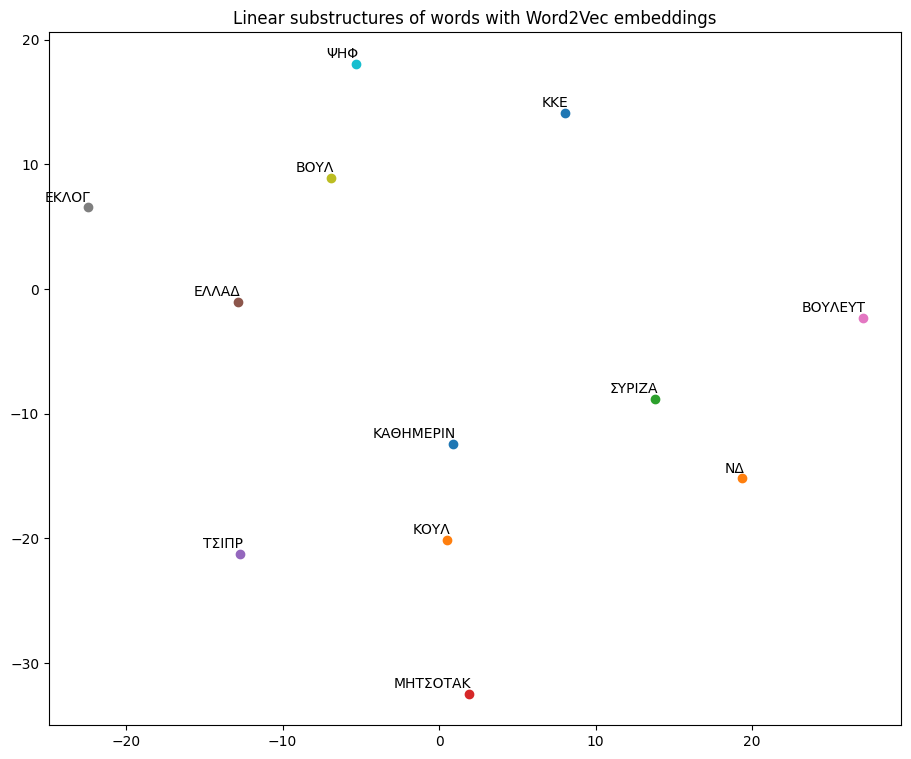

In [7]:
from sklearn.manifold import TSNE
import seaborn as sns

# Word similarities
most_similar_1 = word2vec_model.wv.most_similar('ΝΔ')
most_similar_2 = word2vec_model.wv.most_similar('ΣΥΡΙΖΑ')

print(f'Most semantically similar to word ΝΔ:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_1:
    print(f'{" "*5}{w[0]:15}{w[1]}')

print(f'\n\nMost semantically similar to word ΣΥΡΙΖΑ:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_2:
    print(f'{" "*5}{w[0]:15}{w[1]}')

vocab = ["ΚΚΕ", "ΝΔ", "ΣΥΡΙΖΑ", "ΜΗΤΣΟΤΑΚ", "ΤΣΙΠΡ", "ΕΛΛΑΔ", "ΒΟΥΛΕΥΤ", "ΕΚΛΟΓ", "ΒΟΥΛ", "ΨΗΦ", "ΚΑΘΗΜΕΡΙΝ", "ΚΟΥΛ"]

def glove_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model.wv[word])
        labels.append(word)
    
    wordvecs = np.array(wordvecs)
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(11, 9)) 
    plt.title('Linear substructures of words with Word2Vec embeddings')
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

# Visualize word embeddings
glove_plot(word2vec_model)

In [8]:
# Convert the vectors into numerical
vector_size = 100
X = np.array([np.mean(word2vec_model.wv[line], axis=0) if line and all(word in word2vec_model.wv for word in line) else np.zeros(vector_size) for line in line_vectors])
X_valid = np.array([np.mean(word2vec_model.wv[line], axis=0) if line and all(word in word2vec_model.wv for word in line) else np.zeros(vector_size) for line in line_vectors_valid])
X_test_set = np.array([np.mean(word2vec_model.wv[line], axis=0) if line and all(word in word2vec_model.wv for word in line) else np.zeros(vector_size) for line in line_vectors_test_csv])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Sentiment'])
y_valid_encoded = label_encoder.transform(df_valid_csv['Sentiment'])

assert (label_encoder.transform(label_encoder.classes_) == np.unique(y_encoded)).all(), "Label encoding mismatch"

In [9]:
def pad_sequences(sequences, max_length):
    padded_sequences = []
    for sequence in sequences:
        if len(sequence) < max_length:
            padded_sequence = sequence + [np.zeros(vector_size)] * (max_length - len(sequence))
        else:
            padded_sequence = sequence[:max_length]
        padded_sequences.append(padded_sequence)
    return padded_sequences

# Find the length of the longest tweet
max_length = max(len(sequence) for sequence in line_vectors)

padded_X = pad_sequences(X, max_length)
padded_X_valid = pad_sequences(X_valid, max_length)
padded_X_test = pad_sequences(X_test_set, max_length)

X_tensor = torch.tensor(padded_X, dtype=torch.float32)
X_valid_tensor = torch.tensor(padded_X_valid, dtype=torch.float32)
X_test_tensor = torch.tensor(padded_X_test, dtype=torch.float32)

X_tensor = X_tensor.unsqueeze(-1)
X_valid_tensor = X_valid_tensor.unsqueeze(-1)
X_test_tensor = X_test_tensor.unsqueeze(-1)

X_tensor = X_tensor.expand(-1, -1, vector_size)
X_valid_tensor = X_valid_tensor.expand(-1, -1, vector_size)
X_test_tensor = X_test_tensor.expand(-1, -1, vector_size)

print("Shape of X_tensor:", X_tensor.shape)
print("Shape of X_valid_tensor:", X_valid_tensor.shape)
print("Shape of X_test_tensor:", X_test_tensor.shape)

y_tensor = torch.tensor(y_encoded, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_encoded, dtype=torch.float32)

print ("Shape of y_tensor:", y_tensor.shape)
print ("Shape of y_valid_tensor:", y_valid_tensor.shape)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

/tmp/ipykernel_19/351736255.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X_tensor = torch.tensor(padded_X, dtype=torch.float32)


Shape of X_tensor: torch.Size([36630, 79, 100])
Shape of X_valid_tensor: torch.Size([5232, 79, 100])
Shape of X_test_tensor: torch.Size([10470, 79, 100])
Shape of y_tensor: torch.Size([36630])
Shape of y_valid_tensor: torch.Size([5232])
Shape of X_train: torch.Size([29304, 79, 100])
Shape of y_train: torch.Size([29304])
Shape of X_test: torch.Size([7326, 79, 100])
Shape of y_test: torch.Size([7326])


In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, cell_type, dropout_prob, bidirectional):
        super(RNN, self).__init__()

        cells = {
            "RNN": nn.RNN,
            "LSTM": nn.LSTM,
            "GRU": nn.GRU
        }

        self.cell_type = cell_type

        self.rnn = cells[cell_type](
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0,
            bidirectional=bidirectional  # Set bidirectional to True
        )
        
        if bidirectional:
            self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional RNN/LSTM
        else:
            self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)

        out = self.fc(r_out[:, -1, :])
        return out


[I 2024-02-13 06:14:43,969] A new study created in memory with name: no-name-6cb350c2-a000-4624-a3c2-544b35fcd139
/tmp/ipykernel_19/2926895988.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_prob = trial.suggest_uniform('dropout_prob', 0, 0.5)
/tmp/ipykernel_19/2926895988.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_19/2926895988.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Epoch 1: Loss = 1.09807
Epoch 2: Loss = 1.09677
Epoch 3: Loss = 1.09397
Epoch 4: Loss = 1.09232
Epoch 5: Loss = 1.08998


/tmp/ipykernel_19/2926895988.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_valid = model(torch.tensor(X_test, dtype=torch.float32))
/tmp/ipykernel_19/2926895988.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  accuracy = torch.sum(predicted == torch.tensor(y_test)).item() / len(y_test)


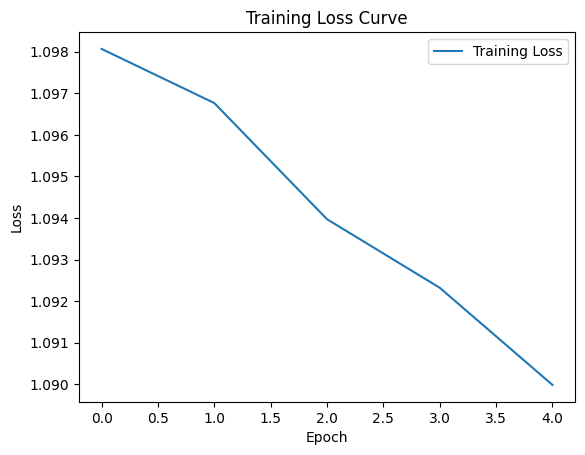

[I 2024-02-13 06:38:30,787] Trial 0 finished with value: 0.3682773682773683 and parameters: {'hidden_size': 128, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.058096024484011244}. Best is trial 0 with value: 0.3682773682773683.


Epoch 1: Loss = 1.09779
Epoch 2: Loss = 1.09609
Epoch 3: Loss = 1.09385
Epoch 4: Loss = 1.09285
Epoch 5: Loss = 1.09070


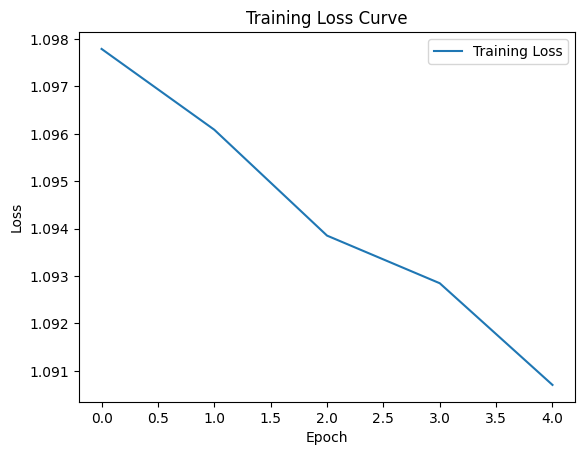

[I 2024-02-13 06:46:55,481] Trial 1 finished with value: 0.3633633633633634 and parameters: {'hidden_size': 64, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.351785093859131}. Best is trial 0 with value: 0.3682773682773683.


Epoch 1: Loss = 1.09899
Epoch 2: Loss = 1.09722
Epoch 3: Loss = 1.09706
Epoch 4: Loss = 1.09500
Epoch 5: Loss = 1.09373


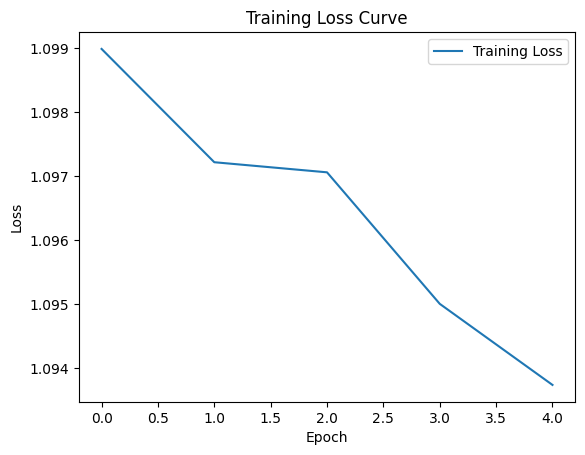

[I 2024-02-13 06:58:25,043] Trial 2 finished with value: 0.35681135681135684 and parameters: {'hidden_size': 64, 'num_layers': 3, 'cell_type': 'GRU', 'dropout_prob': 0.1547412946052884}. Best is trial 0 with value: 0.3682773682773683.


Epoch 1: Loss = 1.09793
Epoch 2: Loss = 1.09673
Epoch 3: Loss = 1.09591
Epoch 4: Loss = 1.09249
Epoch 5: Loss = 1.08918


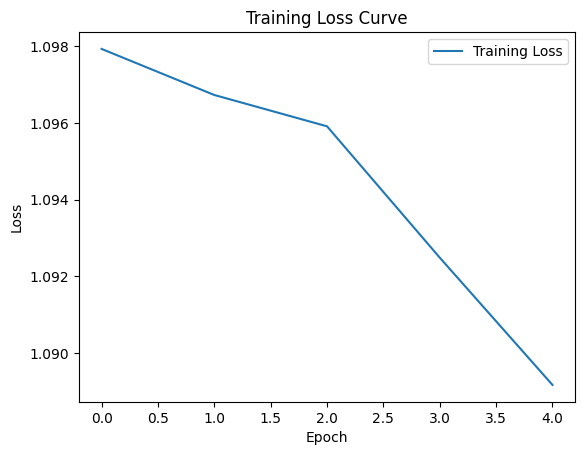

[I 2024-02-13 07:03:04,807] Trial 3 finished with value: 0.36964236964236963 and parameters: {'hidden_size': 128, 'num_layers': 1, 'cell_type': 'LSTM', 'dropout_prob': 0.06658646760375053}. Best is trial 3 with value: 0.36964236964236963.


Epoch 1: Loss = 1.09834
Epoch 2: Loss = 1.09654
Epoch 3: Loss = 1.09555
Epoch 4: Loss = 1.09269
Epoch 5: Loss = 1.08892


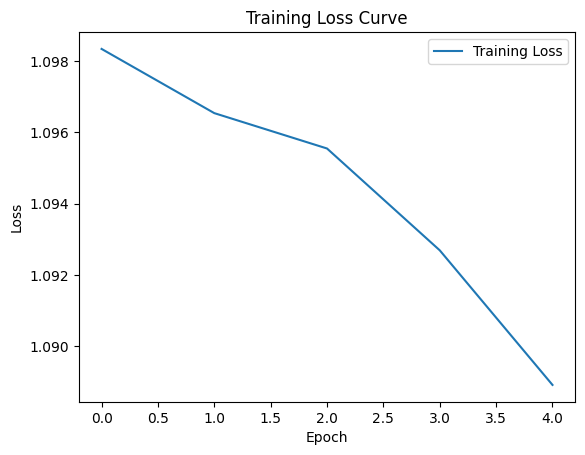

[I 2024-02-13 07:09:41,674] Trial 4 finished with value: 0.3577668577668578 and parameters: {'hidden_size': 128, 'num_layers': 1, 'cell_type': 'LSTM', 'dropout_prob': 0.11494260318827504}. Best is trial 3 with value: 0.36964236964236963.


Epoch 1: Loss = 1.09955
Epoch 2: Loss = 1.09716
Epoch 3: Loss = 1.09697
Epoch 4: Loss = 1.09659
Epoch 5: Loss = 1.09647


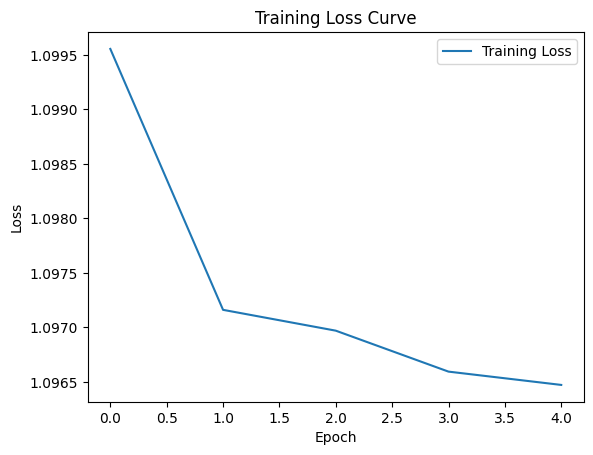

[I 2024-02-13 07:15:19,394] Trial 5 finished with value: 0.358995358995359 and parameters: {'hidden_size': 128, 'num_layers': 1, 'cell_type': 'GRU', 'dropout_prob': 0.20092549261910814}. Best is trial 3 with value: 0.36964236964236963.


Epoch 1: Loss = 1.09908
Epoch 2: Loss = 1.09746
Epoch 3: Loss = 1.09674
Epoch 4: Loss = 1.09626
Epoch 5: Loss = 1.09599


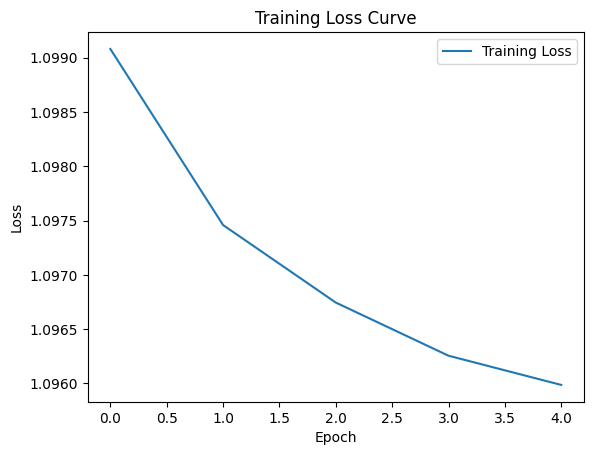

[I 2024-02-13 07:18:57,174] Trial 6 finished with value: 0.34602784602784603 and parameters: {'hidden_size': 64, 'num_layers': 1, 'cell_type': 'GRU', 'dropout_prob': 0.3156537196835982}. Best is trial 3 with value: 0.36964236964236963.


Epoch 1: Loss = 1.09807
Epoch 2: Loss = 1.09585
Epoch 3: Loss = 1.09326
Epoch 4: Loss = 1.09131
Epoch 5: Loss = 1.08842


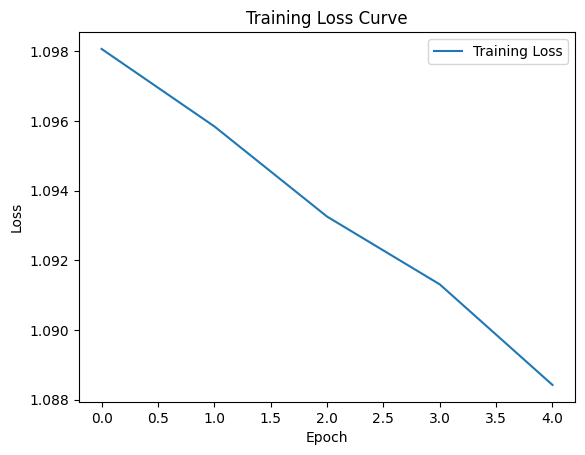

[I 2024-02-13 07:26:49,436] Trial 7 finished with value: 0.3645918645918646 and parameters: {'hidden_size': 64, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.1329453690876991}. Best is trial 3 with value: 0.36964236964236963.


Epoch 1: Loss = 1.09795
Epoch 2: Loss = 1.09668
Epoch 3: Loss = 1.09459
Epoch 4: Loss = 1.09144
Epoch 5: Loss = 1.08997


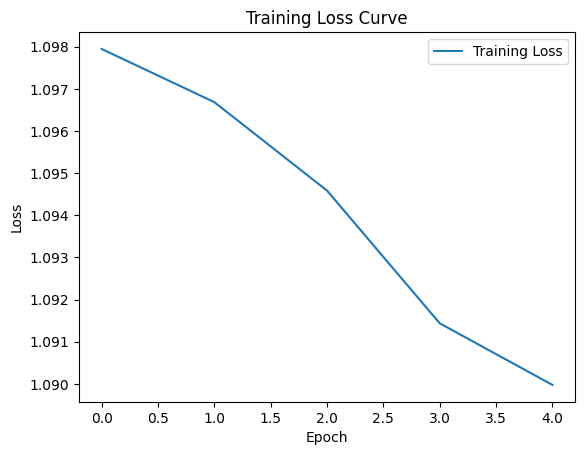

[I 2024-02-13 07:50:46,684] Trial 8 finished with value: 0.35476385476385475 and parameters: {'hidden_size': 128, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.23335793646373676}. Best is trial 3 with value: 0.36964236964236963.


Epoch 1: Loss = 1.09857
Epoch 2: Loss = 1.09702
Epoch 3: Loss = 1.09491
Epoch 4: Loss = 1.09186
Epoch 5: Loss = 1.08980


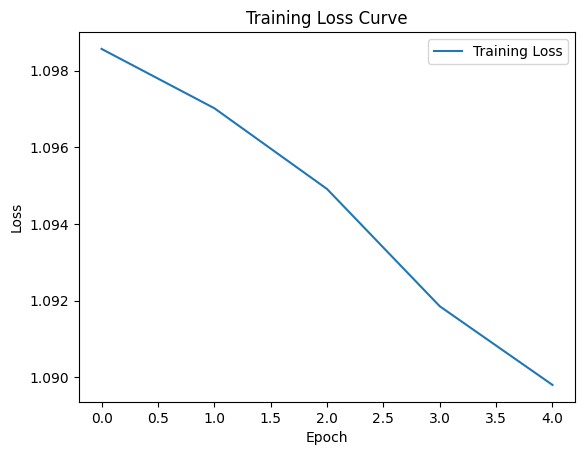

[I 2024-02-13 08:02:08,326] Trial 9 finished with value: 0.3703248703248703 and parameters: {'hidden_size': 64, 'num_layers': 3, 'cell_type': 'GRU', 'dropout_prob': 0.08251528177447148}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09934
Epoch 2: Loss = 1.09778
Epoch 3: Loss = 1.09720
Epoch 4: Loss = 1.09641
Epoch 5: Loss = 1.09560


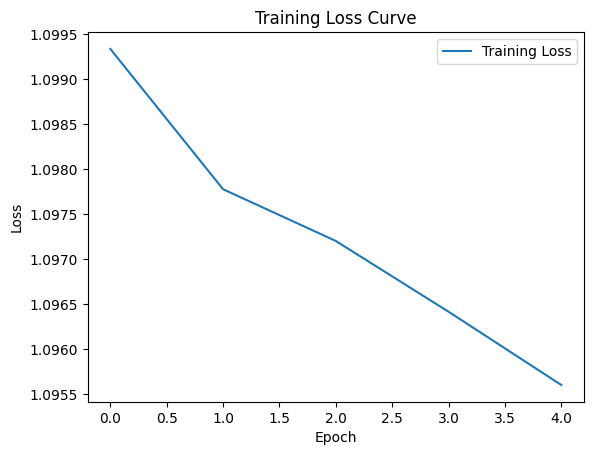

[I 2024-02-13 08:09:30,678] Trial 10 finished with value: 0.3557193557193557 and parameters: {'hidden_size': 64, 'num_layers': 2, 'cell_type': 'GRU', 'dropout_prob': 0.43750542607176307}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09909
Epoch 2: Loss = 1.09728
Epoch 3: Loss = 1.09710
Epoch 4: Loss = 1.09680
Epoch 5: Loss = 1.09570


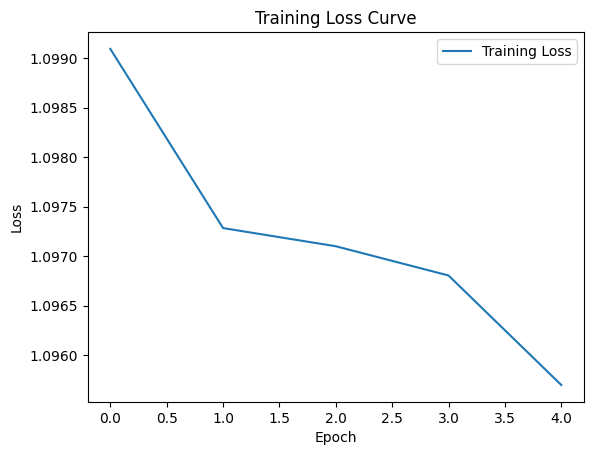

[I 2024-02-13 08:22:11,879] Trial 11 finished with value: 0.35025935025935023 and parameters: {'hidden_size': 128, 'num_layers': 2, 'cell_type': 'GRU', 'dropout_prob': 0.00513551545413983}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09849
Epoch 2: Loss = 1.09706
Epoch 3: Loss = 1.09705
Epoch 4: Loss = 1.09645
Epoch 5: Loss = 1.09453


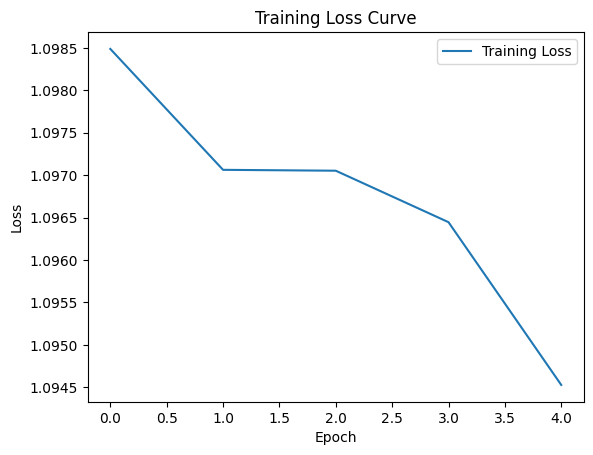

[I 2024-02-13 08:29:41,307] Trial 12 finished with value: 0.35681135681135684 and parameters: {'hidden_size': 64, 'num_layers': 2, 'cell_type': 'GRU', 'dropout_prob': 0.046437726022571464}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09788
Epoch 2: Loss = 1.09665
Epoch 3: Loss = 1.09485
Epoch 4: Loss = 1.09303
Epoch 5: Loss = 1.09040


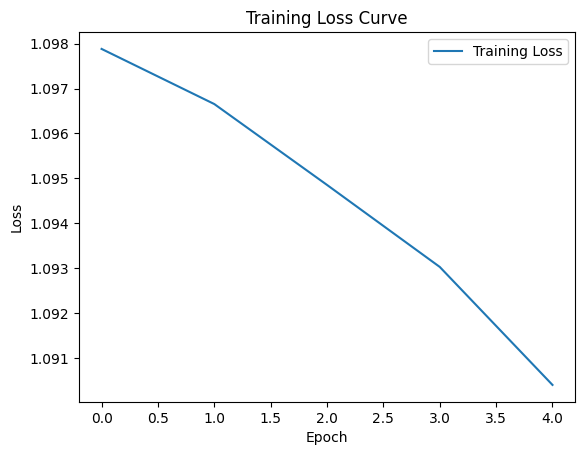

[I 2024-02-13 08:34:22,377] Trial 13 finished with value: 0.3654108654108654 and parameters: {'hidden_size': 128, 'num_layers': 1, 'cell_type': 'LSTM', 'dropout_prob': 0.07374755255705702}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09850
Epoch 2: Loss = 1.09716
Epoch 3: Loss = 1.09532
Epoch 4: Loss = 1.09241
Epoch 5: Loss = 1.09011


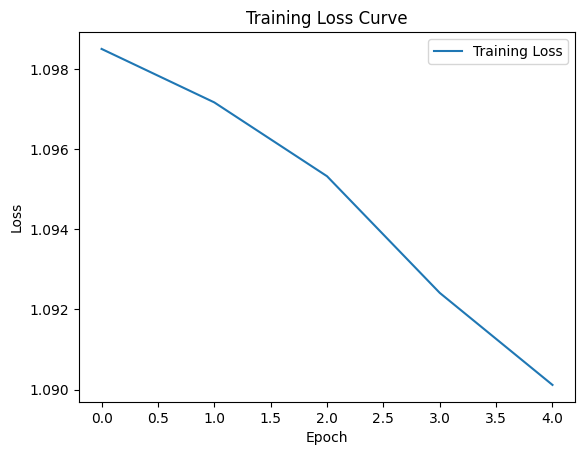

[I 2024-02-13 08:45:14,484] Trial 14 finished with value: 0.36049686049686047 and parameters: {'hidden_size': 128, 'num_layers': 2, 'cell_type': 'LSTM', 'dropout_prob': 0.29534844220767364}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09836
Epoch 2: Loss = 1.09719
Epoch 3: Loss = 1.09702
Epoch 4: Loss = 1.09629
Epoch 5: Loss = 1.09426


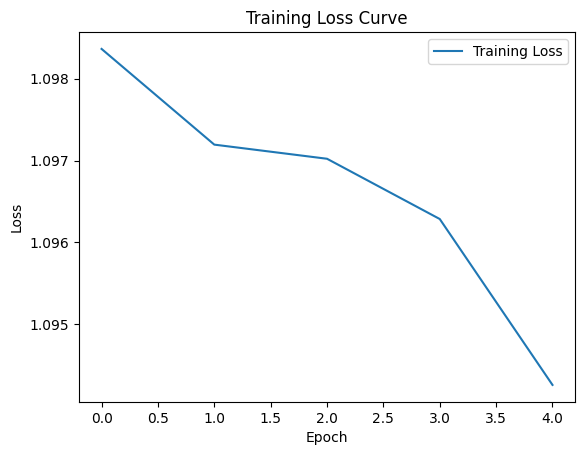

[I 2024-02-13 08:52:46,861] Trial 15 finished with value: 0.3495768495768496 and parameters: {'hidden_size': 64, 'num_layers': 2, 'cell_type': 'GRU', 'dropout_prob': 0.0027788402790096534}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09790
Epoch 2: Loss = 1.09680
Epoch 3: Loss = 1.09622
Epoch 4: Loss = 1.09413
Epoch 5: Loss = 1.09010


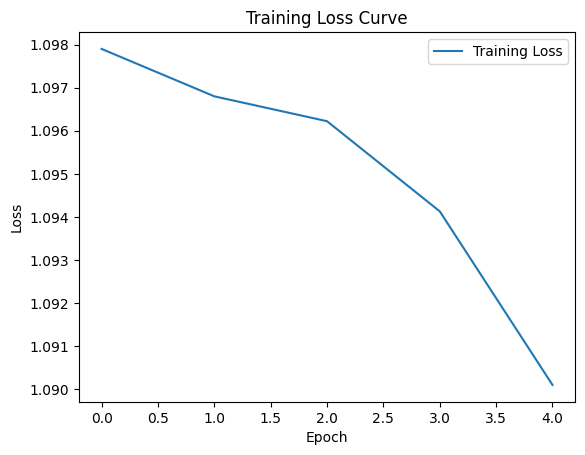

[I 2024-02-13 08:57:21,642] Trial 16 finished with value: 0.36786786786786785 and parameters: {'hidden_size': 128, 'num_layers': 1, 'cell_type': 'LSTM', 'dropout_prob': 0.1806308987775549}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09852
Epoch 2: Loss = 1.09708
Epoch 3: Loss = 1.09627
Epoch 4: Loss = 1.09490
Epoch 5: Loss = 1.09222


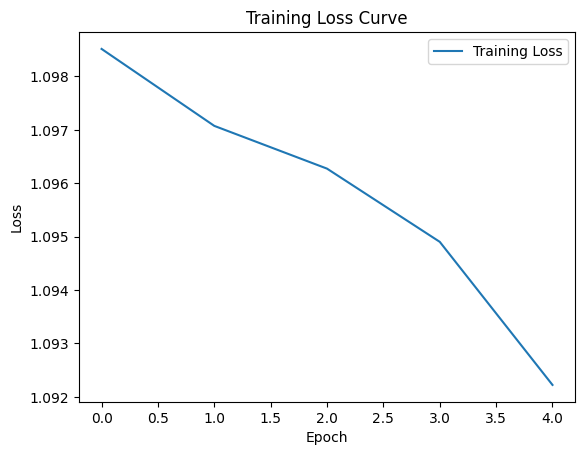

[I 2024-02-13 09:04:47,911] Trial 17 finished with value: 0.3626808626808627 and parameters: {'hidden_size': 64, 'num_layers': 2, 'cell_type': 'GRU', 'dropout_prob': 0.09974517515046111}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09980
Epoch 2: Loss = 1.09752
Epoch 3: Loss = 1.09744
Epoch 4: Loss = 1.09613
Epoch 5: Loss = 1.09391


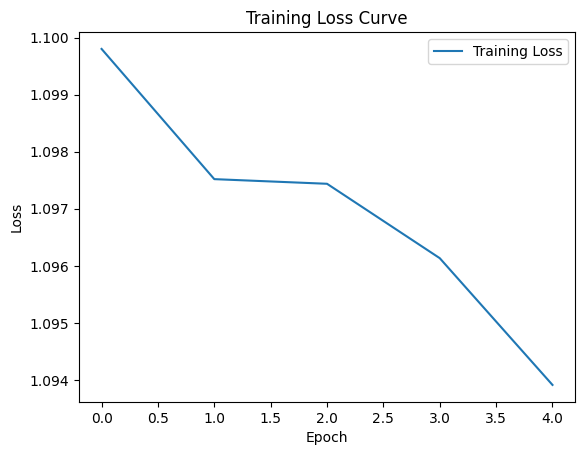

[I 2024-02-13 09:17:30,022] Trial 18 finished with value: 0.3671853671853672 and parameters: {'hidden_size': 128, 'num_layers': 2, 'cell_type': 'GRU', 'dropout_prob': 0.41566384599506967}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09786
Epoch 2: Loss = 1.09604
Epoch 3: Loss = 1.09376
Epoch 4: Loss = 1.09229
Epoch 5: Loss = 1.09019


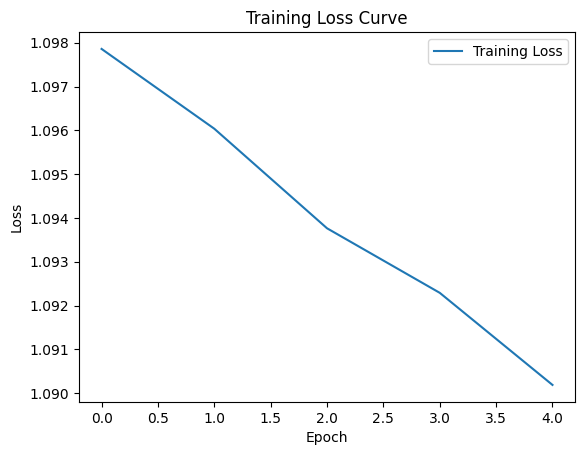

[I 2024-02-13 09:24:07,321] Trial 19 finished with value: 0.3602238602238602 and parameters: {'hidden_size': 64, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.21893312991135522}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09877
Epoch 2: Loss = 1.09678
Epoch 3: Loss = 1.09662
Epoch 4: Loss = 1.09655
Epoch 5: Loss = 1.09646


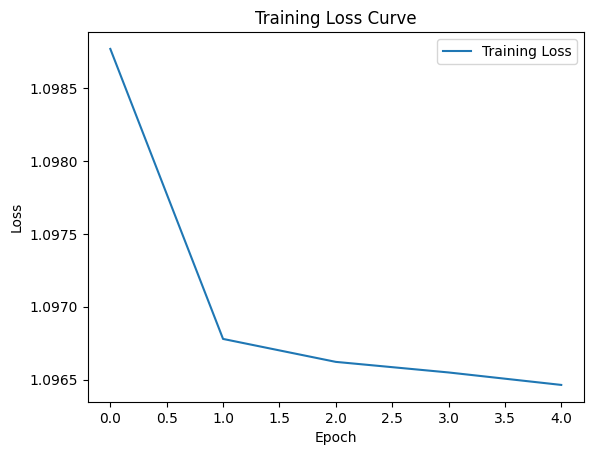

[I 2024-02-13 09:27:47,637] Trial 20 finished with value: 0.3443898443898444 and parameters: {'hidden_size': 64, 'num_layers': 1, 'cell_type': 'GRU', 'dropout_prob': 0.28413784462742203}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09828
Epoch 2: Loss = 1.09718
Epoch 3: Loss = 1.09649
Epoch 4: Loss = 1.09342
Epoch 5: Loss = 1.09435


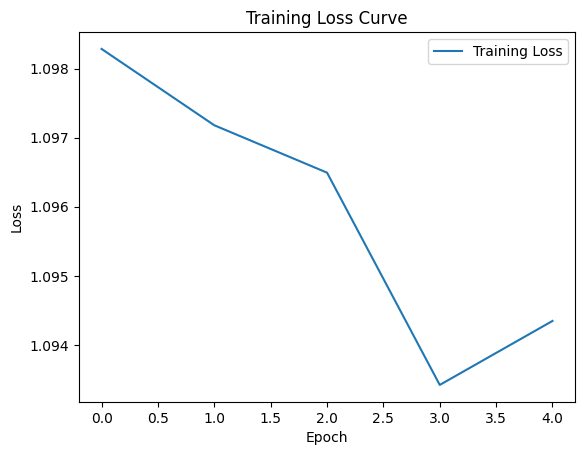

[I 2024-02-13 09:44:48,817] Trial 21 finished with value: 0.3602238602238602 and parameters: {'hidden_size': 128, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.05596496368148825}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09837
Epoch 2: Loss = 1.09708
Epoch 3: Loss = 1.09438
Epoch 4: Loss = 1.09159
Epoch 5: Loss = 1.08898


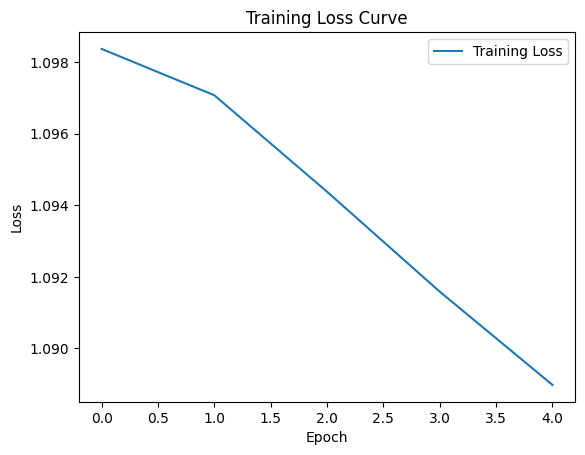

[I 2024-02-13 10:02:08,145] Trial 22 finished with value: 0.3677313677313677 and parameters: {'hidden_size': 128, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.039013584567774}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09858
Epoch 2: Loss = 1.09703
Epoch 3: Loss = 1.09562
Epoch 4: Loss = 1.09275
Epoch 5: Loss = 1.09054


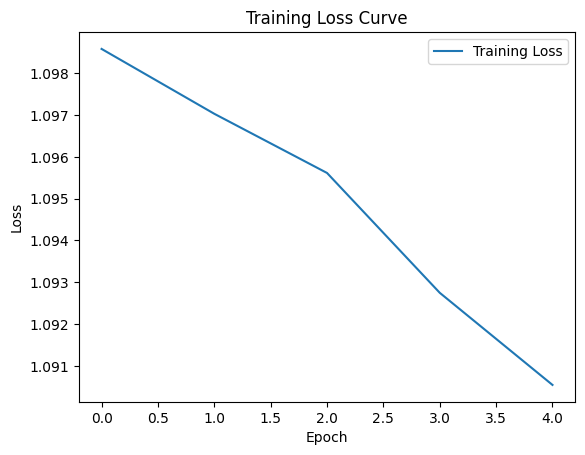

[I 2024-02-13 10:19:27,368] Trial 23 finished with value: 0.3677313677313677 and parameters: {'hidden_size': 128, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.09320314427915134}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09838
Epoch 2: Loss = 1.09782
Epoch 3: Loss = 1.09480
Epoch 4: Loss = 1.09432
Epoch 5: Loss = 1.09095


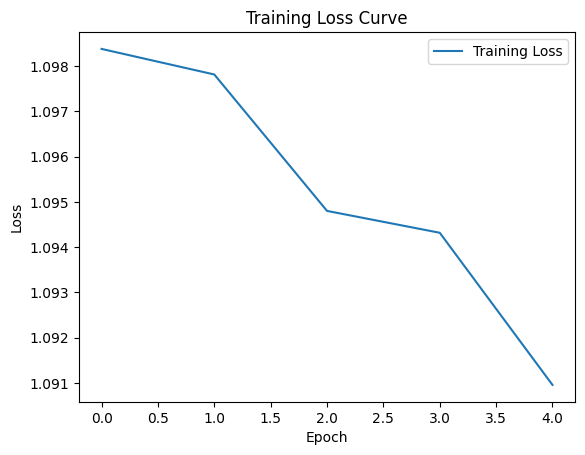

[I 2024-02-13 10:37:23,202] Trial 24 finished with value: 0.35094185094185093 and parameters: {'hidden_size': 128, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.15063332307609886}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09866
Epoch 2: Loss = 1.09714
Epoch 3: Loss = 1.09477
Epoch 4: Loss = 1.09366
Epoch 5: Loss = 1.08989


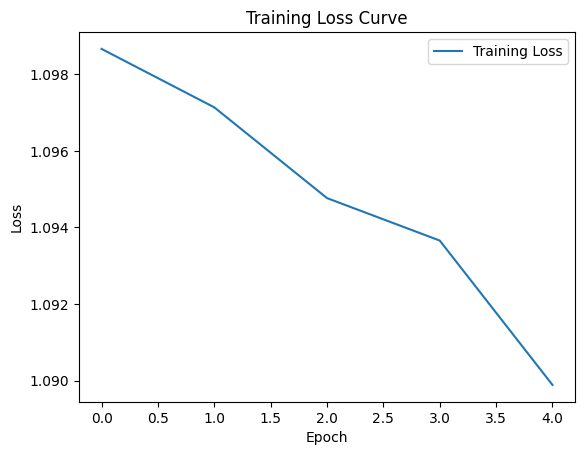

[I 2024-02-13 10:48:00,916] Trial 25 finished with value: 0.36745836745836746 and parameters: {'hidden_size': 128, 'num_layers': 2, 'cell_type': 'LSTM', 'dropout_prob': 0.4821250926271534}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09880
Epoch 2: Loss = 1.09726
Epoch 3: Loss = 1.09762
Epoch 4: Loss = 1.09686
Epoch 5: Loss = 1.09529


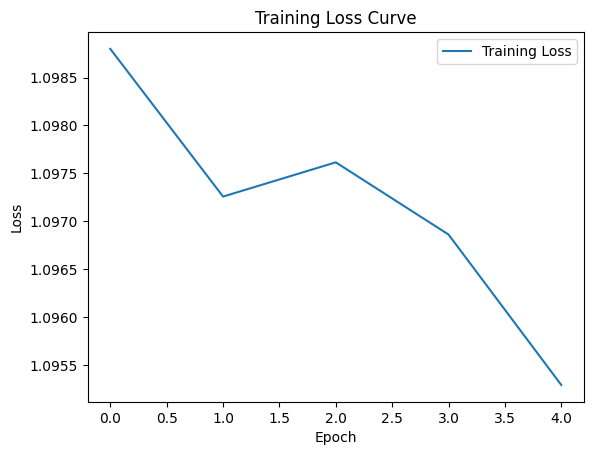

[I 2024-02-13 11:05:45,988] Trial 26 finished with value: 0.35544635544635544 and parameters: {'hidden_size': 128, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.030936363798705305}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09789
Epoch 2: Loss = 1.09722
Epoch 3: Loss = 1.09581
Epoch 4: Loss = 1.09372
Epoch 5: Loss = 1.09124


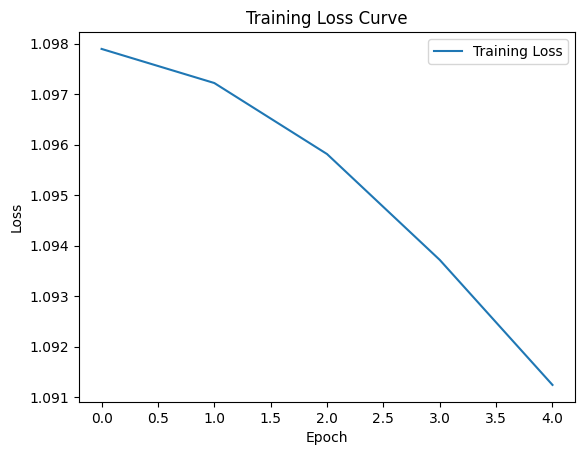

[I 2024-02-13 11:16:37,995] Trial 27 finished with value: 0.36240786240786244 and parameters: {'hidden_size': 128, 'num_layers': 2, 'cell_type': 'LSTM', 'dropout_prob': 0.08446493384069269}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09848
Epoch 2: Loss = 1.09741
Epoch 3: Loss = 1.09505
Epoch 4: Loss = 1.09281
Epoch 5: Loss = 1.09090


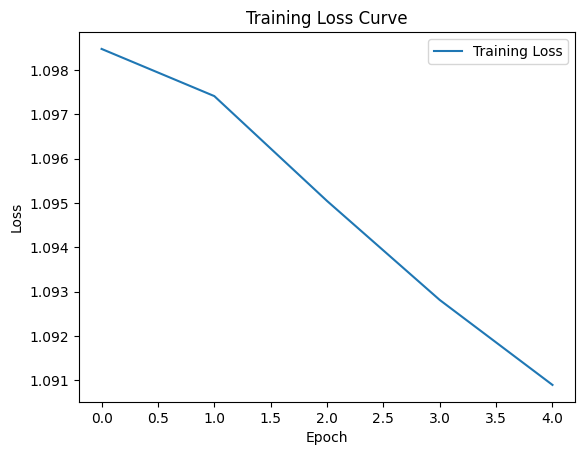

[I 2024-02-13 11:28:50,674] Trial 28 finished with value: 0.35735735735735735 and parameters: {'hidden_size': 64, 'num_layers': 3, 'cell_type': 'GRU', 'dropout_prob': 0.15837399154223958}. Best is trial 9 with value: 0.3703248703248703.


Epoch 1: Loss = 1.09776
Epoch 2: Loss = 1.09587
Epoch 3: Loss = 1.09358
Epoch 4: Loss = 1.09145
Epoch 5: Loss = 1.08986


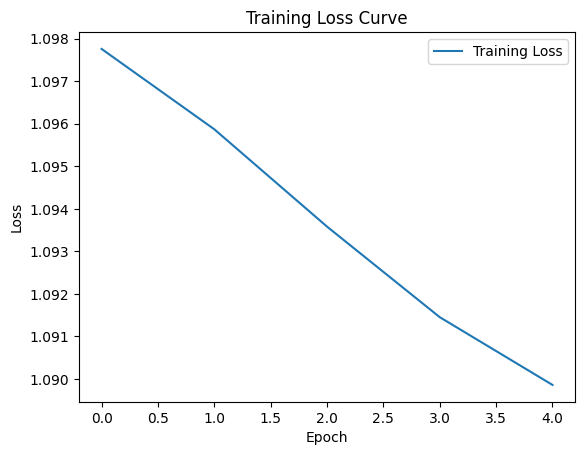

[I 2024-02-13 11:35:20,818] Trial 29 finished with value: 0.35844935844935844 and parameters: {'hidden_size': 64, 'num_layers': 3, 'cell_type': 'LSTM', 'dropout_prob': 0.2623654284257978}. Best is trial 9 with value: 0.3703248703248703.


Best Hyperparameters: {'hidden_size': 64, 'num_layers': 3, 'cell_type': 'GRU', 'dropout_prob': 0.08251528177447148}


In [11]:
EPOCH = 5

def objective(trial):
    # Define hyperparameters to be optimized
    input_size = vector_size
    output_size = len(label_encoder.classes_)
    hidden_size = trial.suggest_categorical('hidden_size', [64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    cell_type = trial.suggest_categorical('cell_type', ['LSTM', 'GRU'])
    dropout_prob = trial.suggest_uniform('dropout_prob', 0, 0.5)
    bidirectional = True

    # Create the RNN model
    model = RNN(input_size, hidden_size, output_size, num_layers, cell_type, dropout_prob, bidirectional)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Train the model
    model.train()
    epoch_losses = []
    for epoch in range(EPOCH):
        batch_losses = []
        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_loss = sum(batch_losses) / len(dataloader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.5f}")

    model.eval()
    with torch.no_grad():
        output_valid = model(torch.tensor(X_test, dtype=torch.float32))
        _, predicted = torch.max(output_valid, 1)
        accuracy = torch.sum(predicted == torch.tensor(y_test)).item() / len(y_test)
    
    plot_loss_curve(epoch_losses)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("Best Hyperparameters:", best_params)


/tmp/ipykernel_19/413866331.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_19/413866331.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Epoch 1: Loss = 1.09875
Epoch 2: Loss = 1.09711
Epoch 3: Loss = 1.09470
Epoch 4: Loss = 1.09286
Epoch 5: Loss = 1.09070


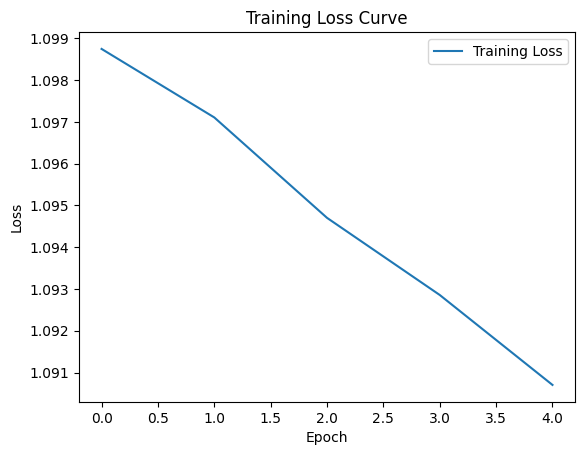

In [12]:
# Use the best hyperparameters for training
best_hidden_size = best_params['hidden_size']
best_num_layers = best_params['num_layers']
best_cell_type = best_params['cell_type']
best_dropout_prob = best_params['dropout_prob']

# Create the RNN model with the best hyperparameters
model = RNN(input_size=vector_size,
            hidden_size=best_hidden_size,
            output_size=len(label_encoder.classes_),
            num_layers=best_num_layers,
            cell_type=best_cell_type,
            dropout_prob=best_dropout_prob,
            bidirectional=True)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Train the model
model.train()
epoch_losses = []
for epoch in range(EPOCH):
    batch_losses = []
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        
    epoch_loss = sum(batch_losses) / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}: Loss = {epoch_loss:.5f}")
    
plot_loss_curve(epoch_losses)

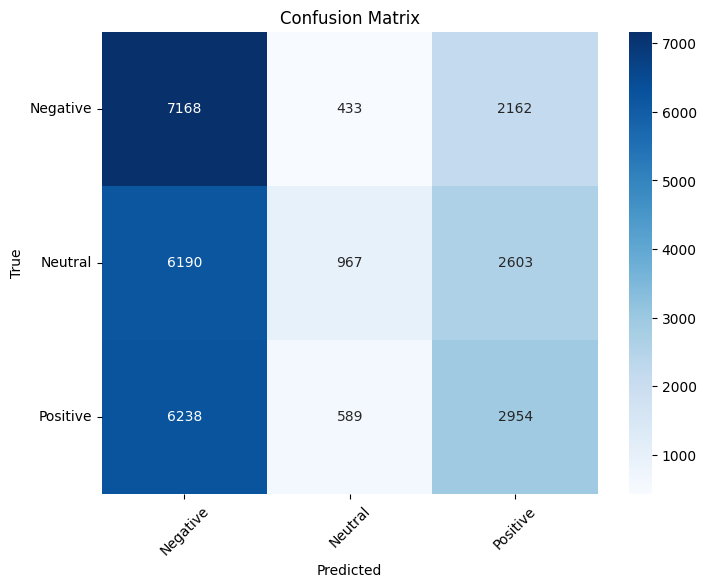

Training Accuracy: 0.3784125034
Classification Report (Training Dataset):
              precision    recall  f1-score   support

    Negative       0.37      0.73      0.49      9763
     Neutral       0.49      0.10      0.16      9760
    Positive       0.38      0.30      0.34      9781

    accuracy                           0.38     29304
   macro avg       0.41      0.38      0.33     29304
weighted avg       0.41      0.38      0.33     29304



In [13]:
# Evaluate the model on the training set
model.eval()
correct_predictions = 0
total_samples = 0
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for x_train_batch, y_train_batch in dataloader:
        y_train_pred = model(x_train_batch)
        _, predicted = torch.max(y_train_pred, 1)

        total_samples += y_train_batch.size(0)
        correct_predictions += (predicted == y_train_batch).sum().item()
        all_true_labels.extend(y_train_batch.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())

training_accuracy = correct_predictions / total_samples

class_names = ['Negative', 'Neutral', 'Positive']

# Plot Confusion Matrix 
y_train_labels = y_train.numpy()
plot_confusion_matrix(model, X_train, y_train_labels, class_names)

classification_report_str = classification_report(all_true_labels, all_pred_labels, target_names=class_names)

print(f"Training Accuracy: {training_accuracy:.10f}")
print("Classification Report (Training Dataset):")
print(classification_report_str)


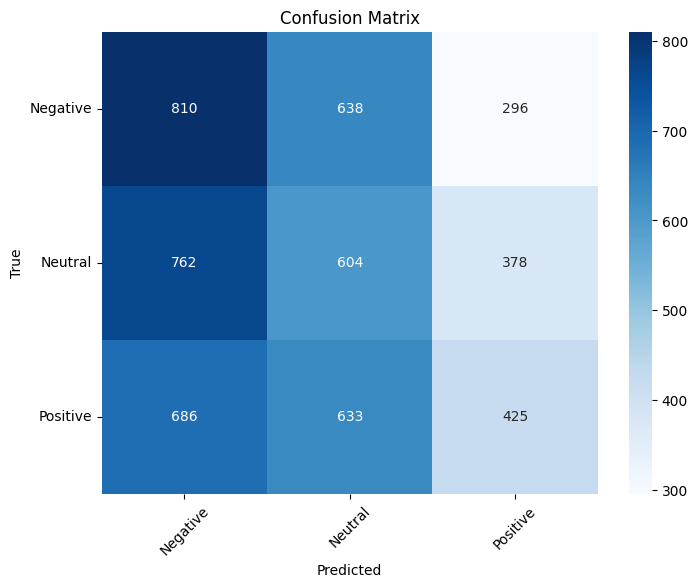

Validation Accuracy: 0.3514908257
Classification Report (Validation Dataset):
              precision    recall  f1-score   support

    Negative       0.36      0.46      0.40      1744
     Neutral       0.32      0.35      0.33      1744
    Positive       0.39      0.24      0.30      1744

    accuracy                           0.35      5232
   macro avg       0.36      0.35      0.35      5232
weighted avg       0.36      0.35      0.35      5232



In [14]:
# Evaluate the model on the validation set
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

model.eval()
correct_predictions_val = 0
total_samples_val = 0
all_true_labels_val = []
all_pred_labels_val = []

with torch.no_grad():
    for x_val_batch, y_val_batch in valid_dataloader:
        y_val_pred = model(x_val_batch)
        _, predicted_val = torch.max(y_val_pred, 1)

        total_samples_val += y_val_batch.size(0)
        correct_predictions_val += (predicted_val == y_val_batch).sum().item()
        all_true_labels_val.extend(y_val_batch.cpu().numpy())
        all_pred_labels_val.extend(predicted_val.cpu().numpy())

validation_accuracy = correct_predictions_val / total_samples_val

# Plot Confusion Matrix for validation set
y_val_labels = y_valid_tensor.numpy()
plot_confusion_matrix(model, X_valid_tensor, y_val_labels, class_names)

classification_report_str_val = classification_report(all_true_labels_val, all_pred_labels_val, target_names=class_names)

print(f"Validation Accuracy: {validation_accuracy:.10f}")
print("Classification Report (Validation Dataset):")
print(classification_report_str_val)

In [15]:
model.eval()

with torch.no_grad():
    predictions = model(X_test_tensor)

_, y_test_csv_pred = torch.max(predictions, 1)

# Inverse transform the predicted labels using the label encoder
predicted_sentiments = label_encoder.inverse_transform(y_test_csv_pred.numpy())

df_id = pd.DataFrame({'Id': df_test_csv['New_ID']})
df_pred = pd.concat([df_id, pd.DataFrame({'Predicted': predicted_sentiments})], axis=1)

csv_file_name = 'submission.csv'
df_pred.to_csv(csv_file_name, index=False)

df_submission = pd.read_csv('submission.csv')
print(df_submission)

          Id Predicted
0          1  NEGATIVE
1          2  POSITIVE
2          3   NEUTRAL
3          4  POSITIVE
4          5   NEUTRAL
...      ...       ...
10465  10466   NEUTRAL
10466  10467  NEGATIVE
10467  10468  POSITIVE
10468  10469   NEUTRAL
10469  10470  NEGATIVE

[10470 rows x 2 columns]
